# 串起来：让机器人可以简单地玩游戏


In [1]:
from CyClient import *
import time
import numpy as np
from matchUtil import *
from Cut import *
import matplotlib.pyplot as plt
from findTemplate import *
cli = Client()
cli.sayHello()

received:     Hello From Server 


In [2]:
cli.takAction(4,0,0)
time.sleep(0.5)
cli.takAction(3,0,0)

received:     M         4         0         0
received:     M         3         0         0


## test

received: 
600 800 3
30000


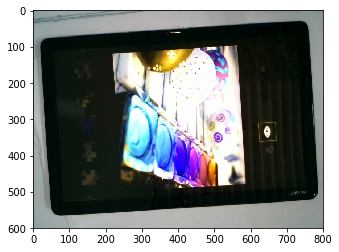

-3.655205488204956


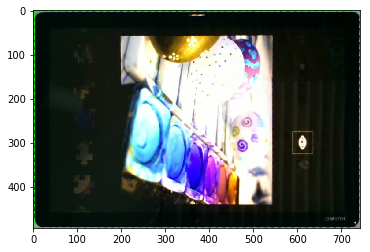

In [3]:
test = cli.getPic()
plt.imshow(test)
plt.show()
cut = get_Contour(test)
plt.imshow(cut)
plt.show()

In [4]:
from matchUtil import *

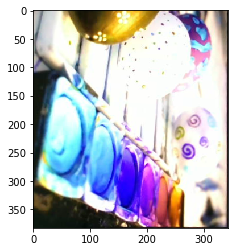

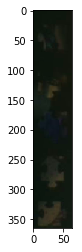

[28, 123]


In [5]:
sor = cutout_source(cut,cut)
plt.imshow(sor)
plt.show()  
#s_x = int(sor.shape[0]/5)
#s_y = int(sor.shape[1]/5)
    
temp_area = cutout_template_area(cut,cut)
plt.imshow(temp_area)
plt.show()
temp_pos = []
temp = cutout_template(cut,cut,temp_pos)
#temp_pos
plt.imshow(temp)
print(temp_pos)

In [70]:
img = ply.getOneShot()
plt.imsave("fullEmpty.png",img)

received: 
600 800 3
30000
-0.0


In [18]:
template = cut
print(temp_pos)
imgshape = template.shape
print(imgshape)
#PHONESIZE = (155,235)
diviceShape = (155,235)
temp_pos_1 = (temp_pos[0]+20 + template.shape[1]*0.114 , temp_pos[1] +25+ template.shape[0]*0.111)
print(temp_pos_1)
x,y =temp_pos_1
#1,0,0,1
x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
y =  y/imgshape[0] * diviceShape[0]
print(x+10,y+10)

[6, 10]
(505, 735, 3)
(109.79, 91.055)
209.89707482993197 37.94757425742574


In [58]:
x,y = temp_pos_1
(1-x/imgshape[1])*

0.8352455418381344

In [14]:
cli.takAction(1,int(x),int(y))

received:     M         1         1 2 5         1 3 7


In [52]:
cli.takAction(1,110,210)

received:     M         1         1 1 0         2 1 0


received: 
600 800 3
30000
0.367279052734375


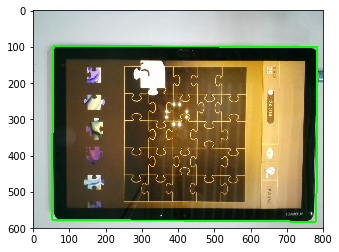

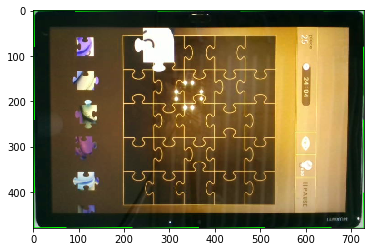

In [60]:
test = cli.getPic()
#plt.imshow(test)
#cv2.imwrite
cut = get_Contour(test)
plt.imshow(test)
plt.show()
#cv2.imwrite("cut_pad.png",cut)
plt.imshow(cut)
plt.show()

# calibration

In [34]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [35]:
cli.takAction(1,170,10)

received:     M         1         1 7 0         1 0


In [36]:
cli.takAction(1,10,255)

received:     M         1         1 0         2 5 5


In [22]:
cli.getPos() # left upper corner  it is 85, 10, 0, right bottom corner is 15 -135 
'''
base
base = 10 10
pad:left upper corner is 165,10 ,right bottom corner is 15,245,
'''


received: 
(10.0, 245.0, 0)


'\nbase\nbase = 10 10\npad:left upper corner is 165,10 ,right bottom corner is 15,245,\n'

In [10]:
# PHONESIZE = (150,235)
PHONESIZE = (160,245)


In [39]:
class Player:
    def __init__(self,cli):
        self.cli = cli
        self.basePoint = np.array([0,0])
        self.sourceimg = None # the image of the jagsaw to recover
        self.emptyimg = None # the image of the empty target area 
    def setBase(self):
        # move to where 0,0 point should be in the figure
        curr = self.cli.getPos()
        print("current position: ", curr[:2])
        self.basePoint = np.array(curr[:2])
    def moveto(self,x,y):
        x += self.basePoint[0]
        y += self.basePoint[1]
        x,y = int(x),int(y)
        cx,cy,_  =self.cli.getPos()
        self.cli.takAction(1,x,y)
         # getPos can not get the current pos, but the target pos
        # the time is 2.76s to move from -10,-10 to 100,100
        speed = 56
        dist = ((x-cx)**2+(y-cy)**2)**(1/2)
        waittime = dist/speed + 0.5
        time.sleep(waittime)
        
        
    def movetoImg(self,x,y,imgshape,diviceShape = PHONESIZE):
        # imgshape is (y_shape, x_shape)
        '''
        x =  (1-x/imgshape[1]) * diviceShape[0] # because x is converted
        y =  y/imgshape[0] * diviceShape[1]
        '''
        x =  (1-x/imgshape[1]) * diviceShape[1] # because x is converted
        y =  y/imgshape[0] * diviceShape[0]
        x,y = y,x
        self.moveto(x,y)
    
    def retreat(self):
        #self.moveto(-10,-10)
        self.moveto(-10,-10)
#         self.cli.takAction(3,0,0)
    
    def clickAtImg(self, x, y,imgshape,diviceShape = PHONESIZE):
        print(imgshape,diviceShape)
        self.movetoImg(x, y,imgshape,diviceShape)
#         time.sleep(2)
#         self.cli.takAction(2,0,0)
        self.cli.takAction(4,0,0)
        time.sleep(0.5)
        self.cli.takAction(3,0,0)
        self.retreat()
    
    def dragAtImg(self, x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE,roundAbout = None):
        self.movetoImg(x0,y0,imgshape,diviceShape)
        self.cli.takAction(4,0,0)
        time.sleep(0.2)
        if(roundAbout is not None):
            x2,y2 = roundAbout
            self.movetoImg(x2,y2,imgshape,diviceShape)
        self.movetoImg(x1,y1,imgshape,diviceShape)
        self.cli.takAction(3,0,0)
    
    def tryOneDrag(self,x0,y0,x1,y1,imgshape,diviceShape = PHONESIZE, shot = False, back = True, roundAbout = None):
        # drag the piece to the position and then drag it back
        # if it is the correct piece it will stay there
#         targetShape = 
        # roundAbout is the point first drag to
        sx = int(imgshape[1]*(0.735-0.273)/10) # the shift amount
        sy = int(imgshape[0]*(0.895-0.120)/10)
#         print("shot:",shot,"back",back)
        self.dragAtImg(x0,y0,x1-sx*1.25,y1+sy,imgshape,PHONESIZE,roundAbout)
        if(shot):
            self.retreat()
#             time.sleep(0.5)
            img = self.getOneShot()
            if(not back):
                return img
        else:
            time.sleep(2)
        #self.dragAtImg(x1,y1+30,x0,y0-30,imgshape,diviceShape = PHONESIZE)
        self.dragAtImg(x1+sx,y1+sy,x0-2*sx,y0,imgshape,diviceShape = PHONESIZE) # Note the x,y = y,x in movetoImg
        self.retreat()
        if(shot):
            return img
        
    def getOneShot(self):
        img = self.cli.getPic()
        img = get_Contour(img)
        return img
    
    def initGame(self):
        # The phone should be before the game start
        self.retreat()
        img = self.getOneShot()
        #source ?
        self.sourceimg = img
        y,x = img.shape[:2]
        #x,y = x*0.502,y*0.237
        x,y = x*0.4,y*0.16
        self.clickAtImg(x,y,img.shape[:2])
        img = self.getOneShot()
        self.emptyimg = cutout_target(img)
        plt.imshow(self.sourceimg)
        plt.show()
        plt.imshow(self.emptyimg)
        plt.show()
               
        
        
ply = Player(cli)

In [40]:
cli.takAction(1,10,10)

received:     M         1         1 0         1 0


In [41]:
ply.setBase()

received: 
(10.0, 10.0, 0)
current position:  (10.0, 10.0)


In [42]:
ply.retreat()

received: 
(10.0, 10.0, 0)
received:     M         1         0         0


received: 
(0.0, 0.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.598673343658447
(493, 742) (160, 245)
received: 
(0.0, 0.0, 0)
received:     M         1         3 5         1 5 7
received:     M         4         0         0
received:     M         3         0         0
received: 
(35.0, 157.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.56565523147583


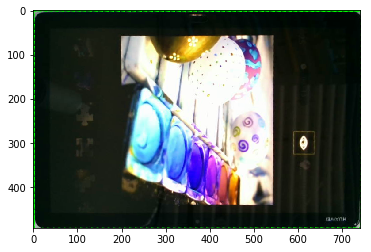

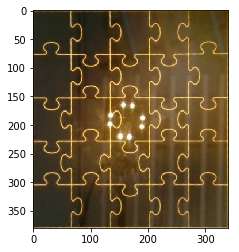

In [43]:
ply.initGame()

In [35]:
#ply.tryOneDrag(100,40, 300,100,ply.sourceimg.shape[:2])
ply.tryOneDrag(430,440, 420,200,ply.sourceimg.shape[:2])
#cli.takAction(1,45,10)

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
ply.sourceimg.shape[:2]

received:     M         1         3 5         0


In [47]:
from matchUtil import *

In [45]:
# ply.movetoImg(82.878+20,203.391+30,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag
ply.movetoImg(150,85,(481,727)) # the +20 and +30 here is to assemble the effect in tryOneDrag

received: 
(35.0, 196.0, 1)
received:     M         1         3 6         1 9 6


In [21]:
cli.takAction(3,0,0)

received:     M         3         0         0


In [37]:
ply.retreat()

received: 
(10.0, 255.0, 0)
received:     M         1         0         0


In [31]:
def DragToCorner(ply,tempPos = None):
    img = ply.getOneShot()
    target = cutout_target(img)
    if(tempPos is None):
        tempPos = []
        _ = cutout_template(None,img.copy(),tempPos)
        x0,y0 = (tempPos[0] + img.shape[1]*0.114 , tempPos[1] + img.shape[0]*0.111)
    else:
        x0,y0 = tempPos
#     (x0,y0), _= matching(ply.sourceimg,img.copy(),mode = "match",debug = True)
    # shift from the corner to the middle of the template
    x0,y0 = x0+10+20, y0+30
    
    x,y = int(img.shape[1]*0.273), int(img.shape[0]*0.120)
    print("###########################")
    print("DRAG TO CORNER tryOneDrag:",x0,y0,x,y,img.shape[:2])
    return ply.tryOneDrag(x0,y0,x,y,img.shape[:2],shot = True,back = False,roundAbout = (x+20,y0))
    
# img = DragToCorner(ply)

In [42]:
# ply.movetoImg(180+20,57+40, [479,730])
# cli.takAction(4,0,0)
ply.movetoImg(199,57, [479,730])

# ply.retreat()

received: 
(41.0, 204.0, 1)
received:     M         1         4 3         2 0 4


In [17]:
def dragToGrid(ply,x0,y0,x1,y1,sor_shape,img_shape,shot,back = True):
    """
    x,y is the cordinate of the source area 0...4
    """
    x0 = int(x0*sor_shape[1]/5 + img_shape[1]*0.273 + sor_shape[1]/10)
    y0 = int(y0*sor_shape[0]/5 + img_shape[0]*0.120 + sor_shape[0]/10)
    x1 = int(x1*sor_shape[1]/5) + int(img_shape[1]*0.273)
    y1 = int(y1*sor_shape[0]/5) + int(img_shape[0]*0.120)
    # to get to the middle of the template
#     x0,y0 = x0 +34, y0+37 # sor_shape[1]/10
    
    print("ply.tryOneDrag",x0,y0,x1,y1,img_shape[:2],shot,back)
    return ply.tryOneDrag(x0,y0,x1,y1,img_shape[:2],shot = shot,back = back)

# img = ply.getOneShot()
# sor = cutout_target(img)
# plt.imshow(sor)
# plt.show()
# dragToGrid(ply,2,2,0,0,sor.shape[:2],img.shape[:2],False)
# dragToGrid(ply,0,0,2,4,sor.shape[:2],img.shape[:2],False)

In [117]:
sor.shape

(373, 337, 3)

In [119]:
ply.movetoImg(233-34-35,94-37+37, [481,729])

received: 
(41.0, 206.0, 1)
received:     M         1         4 1         1 9 9


In [47]:
ply.retreat()

received: 
(41.0, 199.0, 0)
received:     M         1         0         0


In [46]:
cli.takAction(3,0,0)

received:     M         3         0         0


received: 
600 800 3
30000
-4.5692548751831055


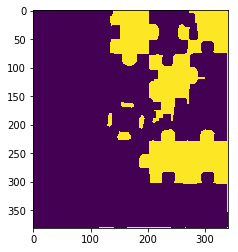

[[  0.           1.57894737 228.60197368  44.25986842 200.92105263]
 [  0.           0.          28.17434211 219.81907895  29.30921053]
 [  0.           5.625       33.79934211  82.15460526  21.95723684]
 [  0.           0.          22.59868421 228.55263158 230.57565789]
 [  0.           0.           0.           0.           0.        ]]
received: 
600 800 3
30000
-4.579805850982666
###########################
DRAG TO CORNER tryOneDrag: 123.132 380.501 201 58 (491, 738)
received: 
(0.0, 0.0, 0)
received:     M         1         1 3 3         2 1 4
received:     M         4         0         0
received: 
(133.0, 214.0, 1)
received:     M         1         1 3 3         1 8 1
received: 
(133.0, 181.0, 1)
received:     M         1         4 4         2 0 2
received:     M         3         0         0
received: 
(44.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.579805850982666


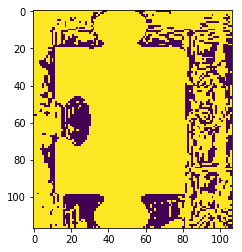

possible: [[ True  True False  True False]
 [ True  True  True False  True]
 [ True  True  True  True  True]
 [ True  True  True False False]
 [ True  True  True  True  True]]
scores: [[0.53304434 0.53973901 0.52689338 0.4271296  0.58533472]
 [0.51424521 0.53421515 0.42379972 0.52586108 0.93797171]
 [0.53257293 0.50607705 0.35197404 0.4291175  0.59110016]
 [0.49507785 0.50579506 0.45091301 0.62092572 0.55309016]
 [0.32096738 0.47911516 0.45308438 0.36943188 0.52679467]]
DRAG TO:  4 1
ply.tryOneDrag 235 97 473 134 (491, 738) True False
received: 
(0.0, 0.0, 0)
received:     M         1         4 1         1 7 6
received:     M         4         0         0
received: 
(41.0, 176.0, 1)
received:     M         1         6 9         1 1 2
received:     M         3         0         0
received: 
(69.0, 112.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.595455169677734


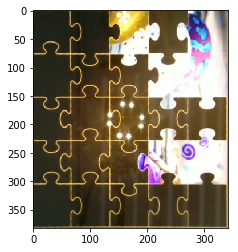

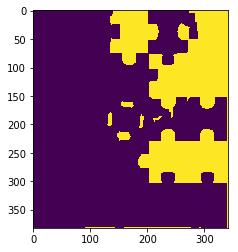

[[  0.           1.62828947 227.31907895  42.97697368 221.99013158]
 [  0.           0.          25.41118421 218.83223684 255.        ]
 [  0.           4.88486842  33.15789474  57.58223684  46.33223684]
 [  0.           0.          20.92105263 230.18092105 231.21710526]
 [  0.           0.           0.           0.           0.        ]]
TRIED: 1
DRAG TO:  3 3
DRAG TO:  4 2
ply.tryOneDrag 508 173 473 210 (491, 738) True False
received: 
(0.0, 0.0, 0)
received:     M         1         6 6         8 6
received:     M         4         0         0
received: 
(66.0, 86.0, 1)
received:     M         1         9 3         1 1 2
received:     M         3         0         0
received: 
(93.0, 112.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.591619968414307


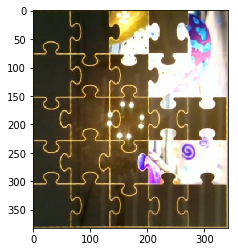

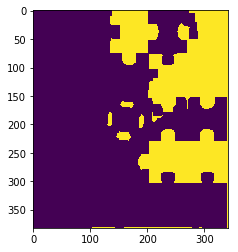

[[  0.           1.72697368 228.30592105  45.         222.77960526]
 [  0.           0.          26.20065789 220.11513158 255.        ]
 [  0.           5.77302632  35.27960526  70.50986842  46.52960526]
 [  0.           0.          23.88157895 230.18092105 230.625     ]
 [  0.           0.           0.           0.           0.        ]]
TRIED: 2


In [49]:
def playOneStep(ply):
    img = ply.getOneShot() # whole screen before move
    target = cutout_target(img.copy())
    
#     (x0,y0), scores = old_matching(ply.sourceimg.copy(),img.copy(),mode = "match",debug = True)
#     print("Template: ",x0,y0,"img shape: ", img.shape[:2])
    #应该还需要10-20的调整
    #为什么有时候会出现不停止直接走然后图像出现异常的情况
    possible = findEmpty(ply.emptyimg,target,mode = "debug")
    moved_template = DragToCorner(ply) # screen after the template is moved to corner
    
    template = find_template(moved_template,img)
#     plt.imshow(template)
#     plt.show()
#     plt.imshow(ply.sourceimg)
#     plt.show()
    source = cutout_target(ply.sourceimg)
    global tmpcount
    cv2.imwrite("tmpTemplate%d.png"%tmpcount,template)
    cv2.imwrite("tmpSource%d.png"%tmpcount,source)
    tmpcount += 1
    scores = matching(source,template)
#     print("Rx,RY",rx,ry)
#     rx,ry = min(4,rx),min(4,ry)
#     rx,ry = int(rx),int(ry)
#     scores = matching(ply.sourceimg,moved_template,img,mode = "match",debug = True)
#     scores[ry][rx] = 99999999
    initial_num = possible.sum()
    print("possible:", possible)
    print("scores:",scores)
    ex,ey = 0,0 # the point to check the correctness
    scores[0][0] = -1
    triedCount = 0
    while(possible.sum()>0):
        y = np.argmax(scores)//5 # x => i 
        x = np.argmax(scores)%5
        print("DRAG TO: ",x,y)
        scores[y][x]=-1
        if(not possible[y][x] ): # we don't have to move to 0,0, we just check it in the next round
            continue
        possible[y][x] = False
        
        timg = dragToGrid(ply,ex,ey,x,y,target.shape[:2],img.shape[:2],shot=True, back = False)
        timg = cutout_target(timg)
#         print("Tries To Drag:",x0,y0,x,y)
        
        triedCount += 1
        
        plt.imshow(timg)
        plt.show()
        empty = findEmpty(ply.emptyimg,timg,mode = "debug")
        print("TRIED:", triedCount )
        if(not empty[ey][ex]):
            break
        ex,ey = x,y
playOneStep(ply)

received: 
600 800 3
30000
-4.589589595794678


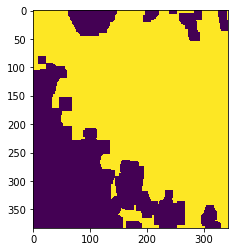

[[250.06578947 118.56907895 236.39802632 220.85526316 180.88815789]
 [122.61513158 255.         255.         255.         255.        ]
 [ 34.34210526 231.46381579 255.         255.         255.        ]
 [  0.          21.71052632 162.23684211 255.         255.        ]
 [  0.           0.          65.82236842 112.54934211 208.56907895]]
received: 
600 800 3
30000
-4.601691722869873
###########################
DRAG TO CORNER tryOneDrag: 120.58800000000001 388.723 202 59 (493, 742)
received: 
(0.0, 0.0, 0)
received:     M         1         1 3 6         2 1 5
received:     M         4         0         0
received: 
(136.0, 215.0, 1)
received:     M         1         1 3 6         1 8 1
received: 
(136.0, 181.0, 1)
received:     M         1         4 4         2 0 2
received:     M         3         0         0
received: 
(44.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.573921203613281


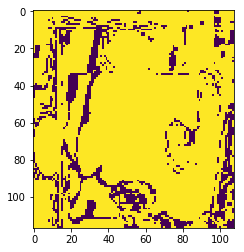

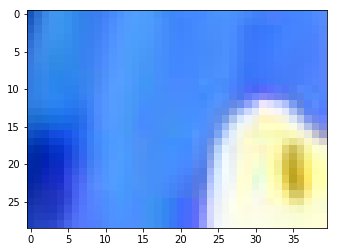

possible: [[False False False False False]
 [False False False False False]
 [ True False False False False]
 [ True  True False False False]
 [ True  True  True False False]]
scores: [[0.54376143 0.7648977  0.29139221 0.18607955 0.52183664]
 [0.59852952 0.44434711 0.30972776 0.38051158 0.26498327]
 [0.50665081 0.60226768 0.35879087 0.4312408  0.44191957]
 [0.46649966 0.45606494 0.48747385 0.43123916 0.44192052]
 [0.21001241 0.40222076 0.46892202 0.35548249 0.38048813]]
DRAG TO:  1 0
DRAG TO:  1 2
DRAG TO:  0 1
DRAG TO:  4 0
DRAG TO:  0 2
ply.tryOneDrag 236 97 202 212 (494, 742) True False
received: 
(0.0, 0.0, 0)
received:     M         1         4 1         1 7 7
received:     M         4         0         0
received: 
(41.0, 177.0, 1)
received:     M         1         9 4         2 0 2
received:     M         3         0         0
received: 
(94.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.594253063201904


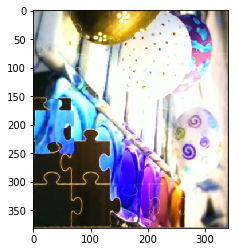

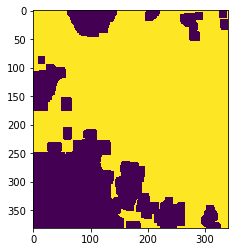

[[249.22697368 116.34868421 239.21052632 226.62828947 186.80921053]
 [127.15460526 255.         255.         255.         255.        ]
 [179.30921053 231.95723684 255.         255.         255.        ]
 [ 47.26973684  24.52302632 166.72697368 255.         255.        ]
 [  0.           0.          69.57236842 127.40131579 208.42105263]]
TRIED: 1
received: 
600 800 3
30000
-4.584662914276123


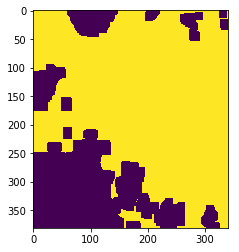

[[249.22697368 116.54605263 238.96381579 226.48026316 187.15460526]
 [135.59210526 255.         255.         255.         255.        ]
 [180.69078947 231.31578947 255.         255.         255.        ]
 [ 46.57894737  24.42434211 167.91118421 255.         255.        ]
 [  0.           0.          69.91776316 128.53618421 208.61842105]]
received: 
600 800 3
30000
-4.610649108886719
###########################
DRAG TO CORNER tryOneDrag: 119.24600000000001 161.501 201 58 (491, 739)
received: 
(0.0, 0.0, 0)
received:     M         1         6 2         2 1 5
received:     M         4         0         0
received: 
(62.0, 215.0, 1)
received:     M         1         6 2         1 8 1
received: 
(62.0, 181.0, 1)
received:     M         1         4 4         2 0 2
received:     M         3         0         0
received: 
(44.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.589590072631836


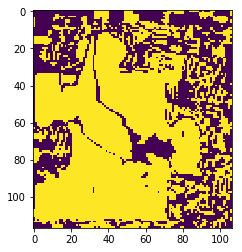

possible: [[False False False False False]
 [False False False False False]
 [False False False False False]
 [ True  True False False False]
 [ True  True  True False False]]
scores: [[0.66575003 0.72050667 0.25849071 0.71493006 0.59155661]
 [0.65533173 0.65533173 0.37489301 0.37474585 0.36032888]
 [0.46494314 0.39573473 0.20895009 0.51364625 0.57140625]
 [0.83059913 0.91992199 0.54395664 0.62955528 0.67373854]
 [0.51579577 0.87825263 0.8106705  0.34077939 0.38577273]]
DRAG TO:  1 3
ply.tryOneDrag 235 97 269 286 (491, 739) True False
received: 
(0.0, 0.0, 0)
received:     M         1         4 1         1 7 7
received:     M         4         0         0
received: 
(41.0, 177.0, 1)
received:     M         1         1 1 8         1 7 9
received:     M         3         0         0
received: 
(118.0, 179.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.610649108886719


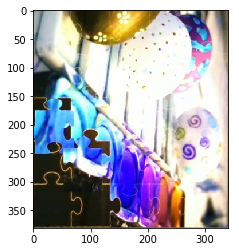

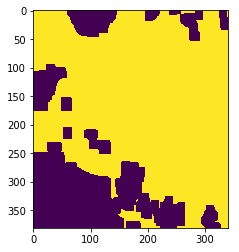

[[249.27631579 116.79276316 238.47039474 218.33881579 183.20723684]
 [134.30921053 255.         255.         255.         255.        ]
 [179.95065789 233.53618421 255.         255.         255.        ]
 [ 57.53289474 148.02631579 174.86842105 255.         255.        ]
 [  0.           0.          69.32565789 122.46710526 206.79276316]]
TRIED: 1
received: 
600 800 3
30000
-4.610649108886719


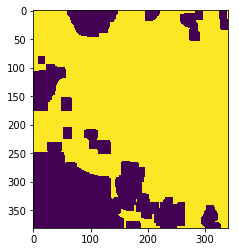

[[249.27631579 116.69407895 237.68092105 226.13486842 183.45394737]
 [126.66118421 255.         255.         255.         255.        ]
 [179.95065789 233.48684211 255.         255.         255.        ]
 [ 57.48355263 147.53289474 173.73355263 255.         255.        ]
 [  0.           0.          69.375      125.42763158 207.58223684]]
received: 
600 800 3
30000
-4.584662914276123
###########################
DRAG TO CORNER tryOneDrag: 133.246 235.612 201 59 (492, 739)
received: 
(0.0, 0.0, 0)
received:     M         1         8 6         2 1 0
received:     M         4         0         0
received: 
(86.0, 210.0, 1)
received:     M         1         8 6         1 8 1
received: 
(86.0, 181.0, 1)
received:     M         1         4 4         2 0 2
received:     M         3         0         0
received: 
(44.0, 202.0, 0)
received:     M         1         0         0
received: 
600 800 3
30000
-4.600095748901367


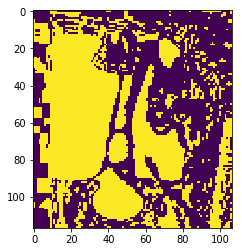

possible: [[False False False False False]
 [False False False False False]
 [False False False False False]
 [ True False False False False]
 [ True  True  True False False]]
scores: [[0.80412763 0.74474221 0.64150345 0.52614439 0.64035612]
 [0.83488768 0.78794479 0.65950447 0.79839844 0.58249879]
 [0.89219391 0.71420652 0.70906085 0.75561726 0.66093349]
 [0.84033769 0.77462083 0.57926279 0.62978274 0.62978274]
 [0.38446888 0.54103941 0.46256921 0.82963163 0.68429381]]
DRAG TO:  0 2
DRAG TO:  0 3
ply.tryOneDrag 235 97 201 286 (491, 739) True False
received: 
(0.0, 0.0, 0)
received:     M         1         4 1         1 7 7
received:     M         4         0         0
received: 
(41.0, 177.0, 1)
received:     M         1         1 1 8         2 0 2
received:     M         3         0         0
received: 
(118.0, 202.0, 0)
received:     M         1         0         0


KeyboardInterrupt: 

In [53]:
for i in range(6):
    playOneStep(ply)

In [19]:
tmpcount = 0

In [108]:
img = ply.getOneShot()
cv2.imwrite("tmp.png",img)



received: 
600 800 3
30000
-1.9349322319030762


True

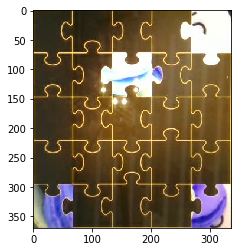

(370, 337, 3)


In [92]:
# ply.movetoImg(197,54,img.shape[:2])
# ply.movetoImg(532,427,img.shape[:2])
sor = cutout_target(img)

plt.imshow(sor)
plt.show()
print(sor.shape)